In [ ]:
print("Hello world")


Hello world


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install --upgrade imutils


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
INIT_LR = 1e-5
EPOCHS = 50
BS = 64


In [ ]:
DIRECTORY = r"/content/drive/MyDrive/data1a/training"
DIRECTORY2=r"/content/drive/MyDrive/data1a/validation"
CATEGORIES = ["00-damage", "01-whole"]

In [ ]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      image = load_img(img_path, target_size=(224, 224))
      image = img_to_array(image)
      image = preprocess_input(image)
      data.append(image)
      labels.append(category)


for category in CATEGORIES:
    path = os.path.join(DIRECTORY2, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)  
      image = load_img(img_path, target_size=(224, 224))
      image = img_to_array(image)
      image = preprocess_input(image)
      data.append(image)
      labels.append(category)
        
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)



(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


[INFO] loading images...


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
import tensorflow as tf
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] training head...
Epoch 1/50
29/29 [==============================] - 38s 877ms/step - loss: 2.8331 - accuracy: 0.4865 - val_loss: 1.4342 - val_accuracy: 0.4849
Epoch 2/50
29/29 [==============================] - 22s 739ms/step - loss: 2.1980 - accuracy: 0.4973 - val_loss: 1.1004 - val_accuracy: 0.5647
Epoch 3/50
29/29 [==============================] - 21s 741ms/step - loss: 1.9617 - accuracy: 0.5399 - val_loss: 0.9973 - val_accuracy: 0.6013
Epoch 4/50
29/29 [==============================] - 23s 800ms/step - loss: 1.7854 - accuracy: 0.5501 - val_loss: 0.9404 - val_accuracy: 0.6315
Epoch 5/50
29/29 [==============================] - 22s 732ms/step - loss: 1.6079 - accuracy: 0.5620 - val_loss: 0.8793 - val_accuracy: 0.6616
Epoch 6/50
29/29 [==============================] - 22s 771ms/step - loss: 1.4591 - accuracy: 0.5889 - val_loss: 0.8307 - val_accuracy: 0.6940
Epoch 7/50
29/29 [==============================] - 22s 741ms/step - loss: 1.3202 - accuracy: 0.6078 - val_loss: 0.792

[INFO] saving mask detector model...


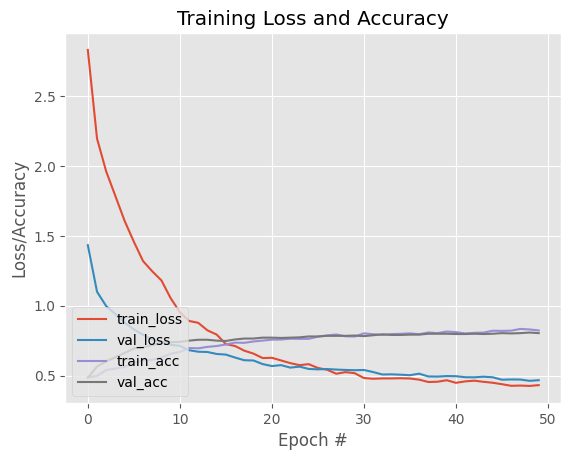

In [ ]:
print("[INFO] saving mask detector model...")
model.save("MobileNet_Car_detection.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("MobileNet.png")

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
from keras import models    
MobileNet = models.load_model("MobileNet_Car_detection.model")

In [ ]:
testURL="/content/drive/MyDrive/data1a/training"
damage_test_url="/content/drive/MyDrive/data1a/validation/00-damage"
whole_test_url="/content/drive/MyDrive/data1a/validation/01-whole"
damage_img = [f'{damage_test_url}/{i}' for i in os.listdir(damage_test_url)]
whole_img=[f'{whole_test_url}/{i}' for i in os.listdir(whole_test_url)]
total_img=damage_img+whole_img

1/1 [==============================] - 0s 35ms/step
Car is Damaged: 0.62082297, Car is not Damaged: 0.37917706
The car is damaged


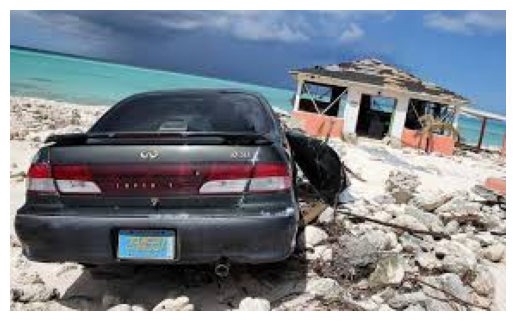

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt
img_path = "/content/drive/MyDrive/data1a/validation/00-damage/0011.JPEG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)


im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(im)

pred=MobileNet.predict(img_batch)
print("Car is Damaged: "+str(pred[0][0])+", Car is not Damaged: "+str(pred[0][1]))
if pred[0][0]<pred[0][1]:
    print("The car is not damaged")
else:
    print("The car is damaged")